Loading and analyzing data...
Dataset Shape: (37500, 19)

Missing Values:
 index                    0
beer/ABV                 0
beer/beerId              0
beer/brewerId            0
beer/name                0
beer/style               0
review/appearance        0
review/aroma             0
review/overall           0
review/palate            0
review/taste             0
review/text             10
review/timeStruct        0
review/timeUnix          0
user/ageInSeconds    29644
user/birthdayRaw     29644
user/birthdayUnix    29644
user/gender          22186
user/profileName         5
dtype: int64


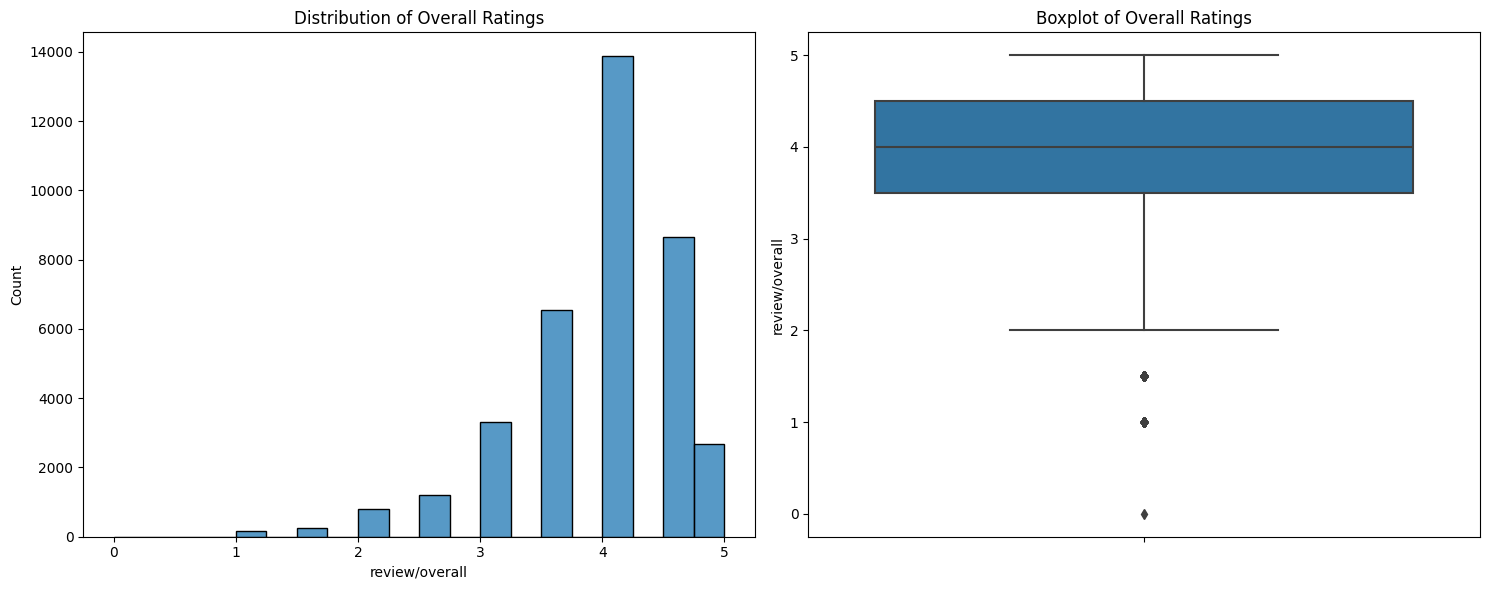


Cleaning and preprocessing data...


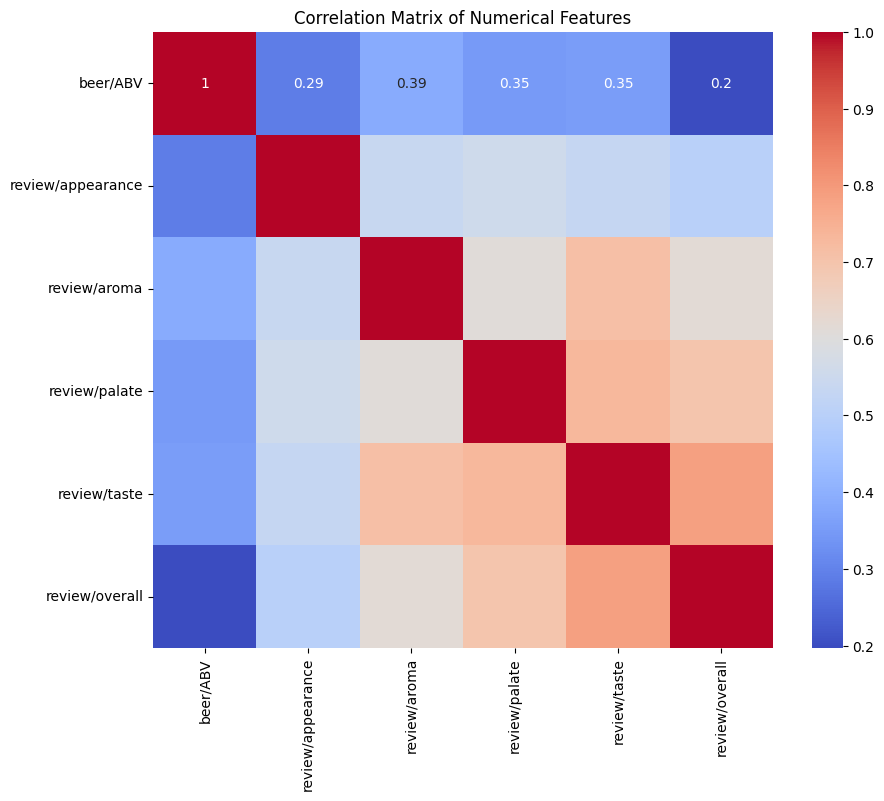


Engineering features...


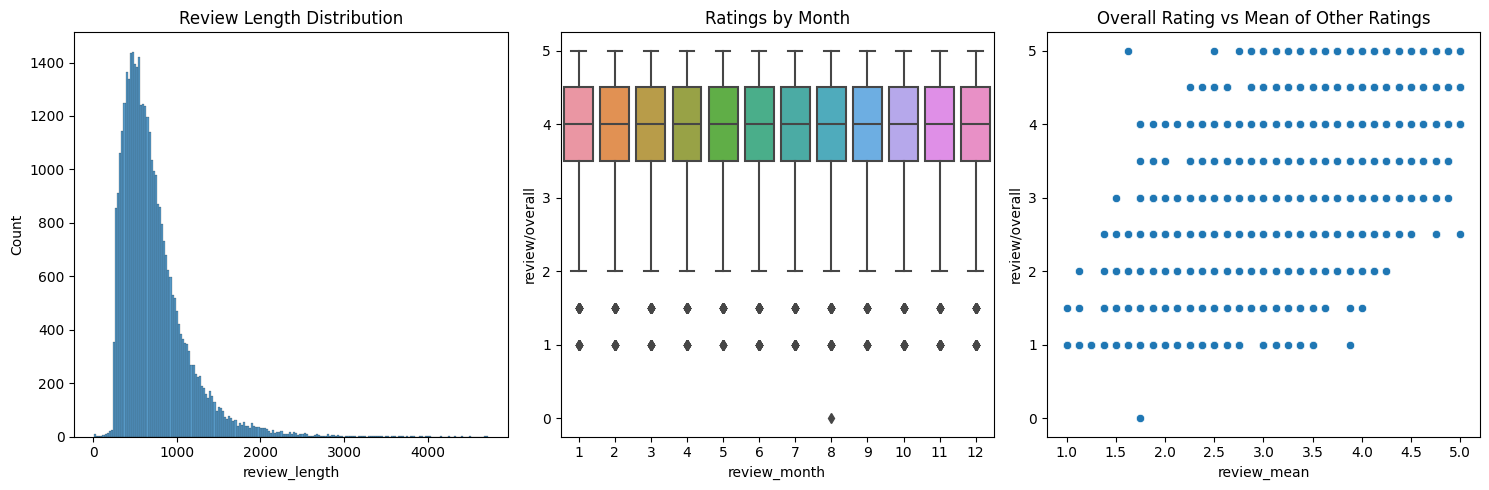


Training and evaluating models...

Training Random Forest...


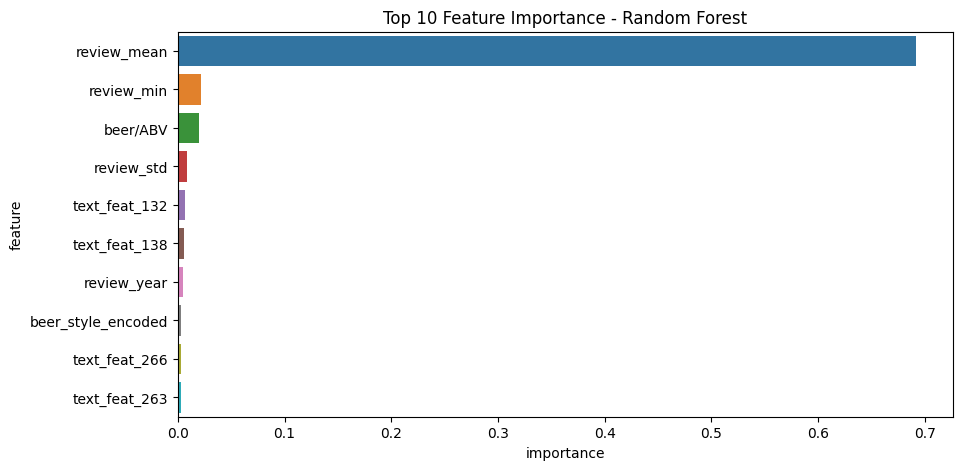


Training XGBoost...


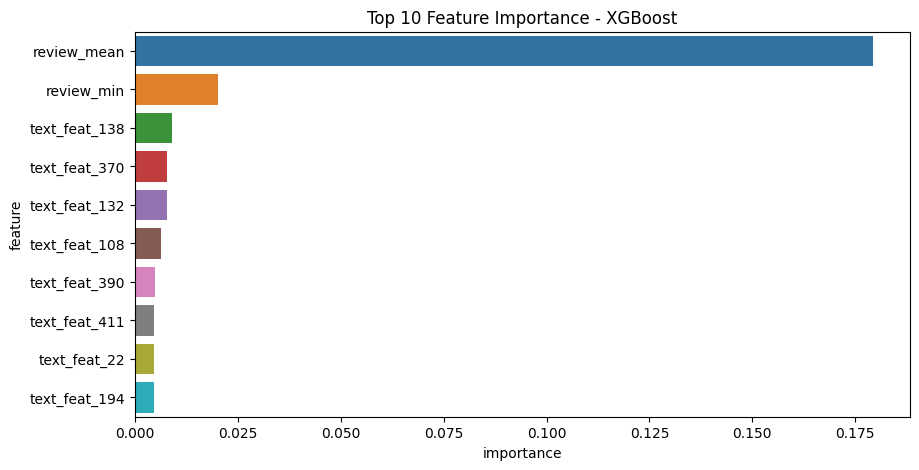

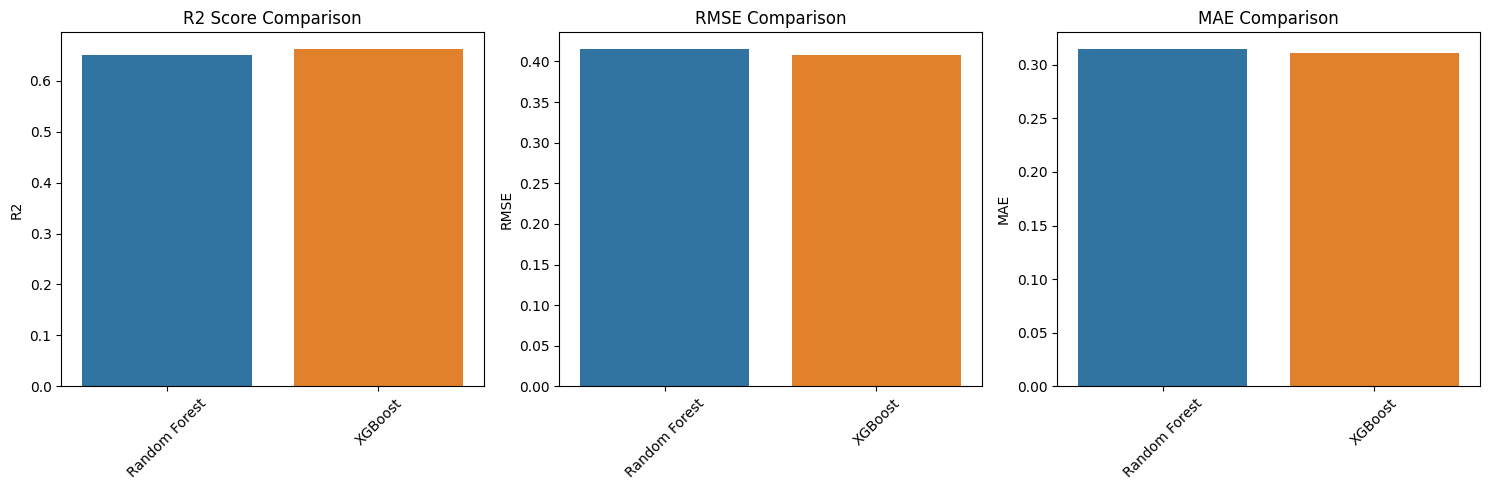


Model Performance Metrics:

Random Forest:
MAE: 0.3144
RMSE: 0.4150
R2: 0.6498

XGBoost:
MAE: 0.3109
RMSE: 0.4079
R2: 0.6619


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb
import warnings

warnings.filterwarnings('ignore')

# 1. Data Loading and Initial Analysis
def load_and_analyze_data(file_path):
    df = pd.read_csv('C:/Users/HP/Downloads/DS_Case_Study_beer-ratings_2020 (2)/DS_Case_Study_beer-ratings_2020/train.csv')
    print("Dataset Shape:", df.shape)
    print("\nMissing Values:\n", df.isnull().sum())

    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(df['review/overall'], bins=20)
    plt.title('Distribution of Overall Ratings')

    plt.subplot(1, 2, 2)
    sns.boxplot(y=df['review/overall'])
    plt.title('Boxplot of Overall Ratings')
    plt.tight_layout()
    plt.show()

    return df

# 2. Data Cleaning and Preprocessing
def clean_preprocess_data(df):
    # Handle missing values
    df['review/text'].fillna('No review', inplace=True)
    df['user/gender'].fillna('Unknown', inplace=True)
    df['review_date'] = pd.to_datetime(df['review/timeUnix'], unit='s')

    # Drop columns with excessive missing values
    df.drop(['user/ageInSeconds', 'user/birthdayRaw', 'user/birthdayUnix'], axis=1, inplace=True)

    # Correlation matrix for numerical features
    numeric_cols = ['beer/ABV', 'review/appearance', 'review/aroma',
                    'review/palate', 'review/taste', 'review/overall']
    plt.figure(figsize=(10, 8))
    sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix of Numerical Features')
    plt.show()

    return df

# 3. Feature Engineering
def engineer_features(df):
    # Text features
    df['review_length'] = df['review/text'].str.len()
    df['review_word_count'] = df['review/text'].str.split().str.len()

    # Time features
    df['review_hour'] = df['review_date'].dt.hour
    df['review_day'] = df['review_date'].dt.day
    df['review_month'] = df['review_date'].dt.month
    df['review_year'] = df['review_date'].dt.year

    # Statistical features
    review_cols = ['review/appearance', 'review/aroma', 'review/palate', 'review/taste']
    df['review_mean'] = df[review_cols].mean(axis=1)
    df['review_std'] = df[review_cols].std(axis=1)
    df['review_max'] = df[review_cols].max(axis=1)
    df['review_min'] = df[review_cols].min(axis=1)

    # Categorical encoding
    le = LabelEncoder()
    df['beer_style_encoded'] = le.fit_transform(df['beer/style'])
    df['gender_encoded'] = le.fit_transform(df['user/gender'])

    # Text vectorization with expanded feature set
    tfidf = TfidfVectorizer(max_features=500, stop_words='english', ngram_range=(1, 2))
    text_features = tfidf.fit_transform(df['review/text'])
    text_cols = [f'text_feat_{i}' for i in range(text_features.shape[1])]
    text_df = pd.DataFrame(text_features.toarray(), columns=text_cols)

    # Visualizations
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    sns.histplot(df['review_length'])
    plt.title('Review Length Distribution')

    plt.subplot(1, 3, 2)
    sns.boxplot(x='review_month', y='review/overall', data=df)
    plt.title('Ratings by Month')

    plt.subplot(1, 3, 3)
    sns.scatterplot(x='review_mean', y='review/overall', data=df)
    plt.title('Overall Rating vs Mean of Other Ratings')
    plt.tight_layout()
    plt.show()

    return pd.concat([df, text_df], axis=1)

# 4. Model Training and Evaluation
def train_evaluate_models(X, y):
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Standardization
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Models with hyperparameter tuning
    rf_params = {'n_estimators': [100, 200], 'max_depth': [10, 20], 'min_samples_split': [5, 10]}
    rf = GridSearchCV(RandomForestRegressor(random_state=42), rf_params, cv=3)
    rf.fit(X_train_scaled, y_train)

    xgb_params = {'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]}
    xgb_model = GridSearchCV(xgb.XGBRegressor(random_state=42), xgb_params, cv=3)
    xgb_model.fit(X_train_scaled, y_train)

    # Evaluate
    models = {'Random Forest': rf.best_estimator_, 'XGBoost': xgb_model.best_estimator_}
    results = {}

    for name, model in models.items():
        print(f"\nTraining {name}...")
        y_pred = model.predict(X_test_scaled)

        results[name] = {
            'MAE': mean_absolute_error(y_test, y_pred),
            'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
            'R2': r2_score(y_test, y_pred)
        }

        if hasattr(model, 'feature_importances_'):
            feature_importance = pd.DataFrame({
                'feature': X.columns,
                'importance': model.feature_importances_
            }).sort_values('importance', ascending=False)

            plt.figure(figsize=(10, 5))
            sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
            plt.title(f'Top 10 Feature Importance - {name}')
            plt.show()

    # Model comparison visualization
    metrics_df = pd.DataFrame(results).T

    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    sns.barplot(x=metrics_df.index, y=metrics_df['R2'])
    plt.title('R2 Score Comparison')
    plt.xticks(rotation=45)

    plt.subplot(132)
    sns.barplot(x=metrics_df.index, y=metrics_df['RMSE'])
    plt.title('RMSE Comparison')
    plt.xticks(rotation=45)

    plt.subplot(133)
    sns.barplot(x=metrics_df.index, y=metrics_df['MAE'])
    plt.title('MAE Comparison')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    return results, models

# Main execution
def main():
    file_path = 'train.csv'  # Update with the correct file path
    print("Loading and analyzing data...")
    df = load_and_analyze_data(file_path)

    print("\nCleaning and preprocessing data...")
    cleaned_df = clean_preprocess_data(df)

    print("\nEngineering features...")
    processed_df = engineer_features(cleaned_df)

    feature_cols = ['beer/ABV', 'review_length', 'review_word_count',
                    'review_hour', 'review_day', 'review_month', 'review_year',
                    'review_mean', 'review_std', 'review_max', 'review_min',
                    'beer_style_encoded', 'gender_encoded'] + \
                   [col for col in processed_df.columns if 'text_feat_' in col]

    X = processed_df[feature_cols]
    y = processed_df['review/overall']

    print("\nTraining and evaluating models...")
    results, models = train_evaluate_models(X, y)

    print("\nModel Performance Metrics:")
    for model, metrics in results.items():
        print(f"\n{model}:")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")

if __name__ == "__main__":
    main()
